In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import feather

In [2]:
# pandas.DataFrame 效能處理設定
# nthreads: Number of CPU threads to use when reading to pandas.DataFrame
# import feather
# feather = pd.read_feather('rawdata/train.csv', nthreads=2)

In [3]:
# pandas.DataFrame 讀取 csv
train = pd.read_csv('rawdata/train.csv')

In [4]:
# 欄位索引
# ip: ip address of click.
# app: app id for marketing.
# device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
# os: os version id of user mobile phone
# channel: channel id of mobile ad publisher
# click_time: timestamp of click (UTC) {test-reference for making predictions}
# attributed_time: if user download the app for after clicking an ad, this is the time of the app download
# is_attributed: the target that is to be predicted, indicating the app was downloaded {test-not included}
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 8 columns):
ip                 int64
app                int64
device             int64
os                 int64
channel            int64
click_time         object
attributed_time    object
is_attributed      int64
dtypes: int64(6), object(2)
memory usage: 11.0+ GB


In [5]:
train.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0


In [6]:
# 設定欄位為類別變項
categorical_columns = ["ip", "app", "device", "os", "channel", "is_attributed"]

for column in categorical_columns:
    train[column] = train[column].astype('category')

In [7]:
# 設定欄位為 datatime 格式
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 8 columns):
ip                 category
app                category
device             category
os                 category
channel            category
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed      category
dtypes: category(6), datetime64[ns](2)
memory usage: 5.0 GB


In [9]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,184903890.0,184903890.0,184903890.0,184903890.0,184903890.0,184903890,456846,184903890.0
unique,277396.0,706.0,3475.0,800.0,202.0,259620,182057,2.0
top,5348.0,3.0,1.0,19.0,280.0,2017-11-07 14:00:11,2017-11-08 14:16:29,0.0
freq,1238734.0,33911780.0,174330052.0,44181914.0,15065927.0,1502,14,184447044.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 16:00:00,NaN


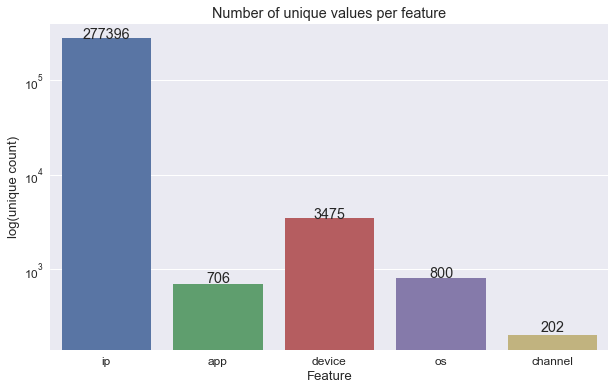

In [10]:
# Visul
plt.figure(figsize=(10, 6))
cols = ["ip", "app", "device", "os", "channel"]
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel="Feature", ylabel="log(unique count)", title="Number of unique values per feature")

# Places the value just above the column
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            uniq,
            ha="center")

In [11]:
# Grabs a subset of the DataFrame and then further grabs only the rows where `is_attributed` is set, then calculating the counts
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,456846,456846.0
unique,182057,1.0
top,2017-11-08 14:16:29,1.0
freq,14,456846.0
first,2017-11-06 16:00:47,NaN
last,2017-11-09 16:00:00,NaN


In [12]:
# Quick Take Aways
# The training set takes place over two days, two hours and eleven seconds
# Out of 184,903,890 rows, only 456,846 of them have an attributed_time values of 1.0
# This means only 456,846 out of 184,903,890 ad clicks resulted in a download
# Which is about 0.0025 % of the clicks
# There is atleast one ip adress that triggers an ad click over fifty thousand times
# Seems strange that one ip address would click that often in a span of just 4 days
# Does that mean that ip address encoded is not device id, but network id? (explore this below)
# Our data is incredilby unbalanced. We're visualizing here the small percents of ad clicks resulting in a download.

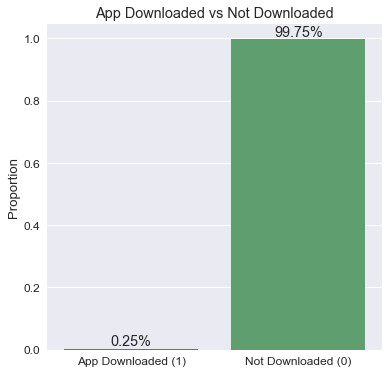

In [13]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')

for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")


In [14]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,1238734
1,5314,1171448
2,73516,770451
3,73487,763854
4,53454,498186
5,114276,427453
6,26995,401495
7,95766,378693
8,17149,310996
9,105475,302192


In [15]:
train= train.merge(temp, on='ip', how='left')

In [16]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7236133,5348,3,1,41,480,2017-11-06 23:09:14,2017-11-06 23:09:15,1,1238734
54746662,5348,29,2,17,343,2017-11-07 14:19:20,2017-11-07 14:25:10,1,1238734
16559430,5348,107,1,10,171,2017-11-07 02:06:20,2017-11-07 10:09:16,1,1238734
178906362,5348,29,1,19,210,2017-11-09 14:07:48,2017-11-09 14:10:39,1,1238734
39328788,5348,43,1,16,330,2017-11-07 09:25:56,2017-11-07 09:53:30,1,1238734
39331561,5348,29,1,13,343,2017-11-07 09:25:59,2017-11-07 09:26:06,1,1238734
98050686,5348,45,1,9,411,2017-11-08 08:59:23,2017-11-08 11:27:22,1,1238734
48883725,5348,29,1,27,210,2017-11-07 12:28:20,2017-11-07 12:36:01,1,1238734
165853667,5348,20,1,12,259,2017-11-09 10:16:33,2017-11-09 11:18:16,1,1238734
172927660,5348,19,0,50,213,2017-11-09 12:23:26,2017-11-09 12:23:27,1,1238734


In [17]:
train[train['is_attributed']==1].ip.describe()

count     456846
unique    245038
top         5348
freq        2340
Name: ip, dtype: int64

In [18]:
# convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

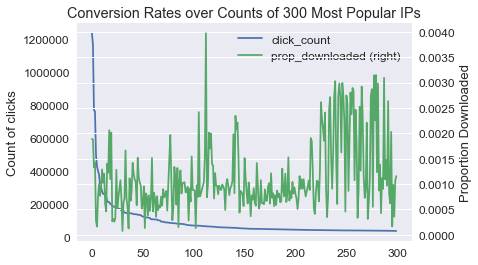

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0     5348      1238734         0.001889
1     5314      1171448         0.001878
2    73516       770451         0.001330
3    73487       763854         0.001428
4    53454       498186         0.000275
5   114276       427453         0.000159
6    26995       401495         0.000747
7    95766       378693         0.001001
8    17149       310996         0.000765
9   105475       302192         0.000943
10  100275       276799         0.001290
11   43793       261970         0.001027
12  105560       260049         0.001204
13   86767       257649         0.000617
14  111025       247187         0.000461
15  137052       217614         0.001402
16  201182       212448         0.001224
17    5178       211556         0.002061
18   49602       200053         0.001100
19    5147       197994         0.002015


In [19]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

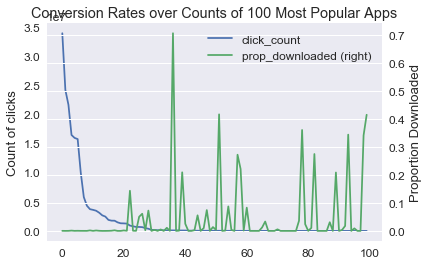

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    3     33911780         0.000303
1   12     24179003         0.000109
2    2     21642136         0.000262
3    9     16458268         0.001144
4   15     15958970         0.000214
5   18     15756587         0.000503
6   14     10027169         0.000250
7    1      5796274         0.000212
8   13      4329409         0.000167
9    8      3731948         0.001842
10  21      3616407         0.000133
11  11      3466971         0.001555
12  26      3126136         0.000467
13  23      2675259         0.000019
14   6      2464136         0.000083
15  64      1893969         0.000266
16   7      1764954         0.000670
17  20      1758934         0.002176
18  25      1467907         0.000047
19  28      1311496         0.000082


In [20]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

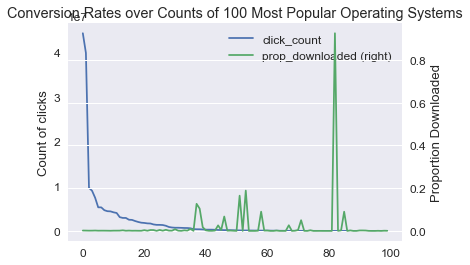

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19     44181914         0.001803
1   13     39782808         0.001549
2   17      9639776         0.001180
3   18      8974159         0.001302
4   22      7414405         0.001769
5    8      5278317         0.001063
6   10      5262422         0.001195
7    6      4632561         0.001184
8   15      4408470         0.000995
9    9      4370878         0.000730
10  25      4156096         0.001219
11  20      4013563         0.001257
12  16      3081268         0.001371
13  37      2905944         0.002832
14   3      2904808         0.000845
15  14      2503681         0.001545
16  41      2467180         0.000808
17   1      2215593         0.001035
18  12      2006410         0.000756
19  23      1844222         0.000681


In [21]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

In [22]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
     device  click_count  prop_downloaded
0         1    174330052         0.001758
1         2      8105054         0.000274
2         0      1033413         0.098525
3      3032       692891         0.000006
4      3543       266596         0.000011
5      3866       178274         0.000011
6        59        24018         0.000874
7         5        14379         0.000000
8         6        12569         0.233670
9        40        12351         0.210914
10       16        10147         0.217010
11       18         6742         0.218481
12       21         5430         0.211786
13       33         5337         0.206108
14       30         4199         0.190998
15      154         4011         0.162553
16       67         3770         0.214589
17      114         3585         0.200279
18       37         3474         0.191710
19       88         3262         0.228081
20        7         3075         0.197398
21       46         3

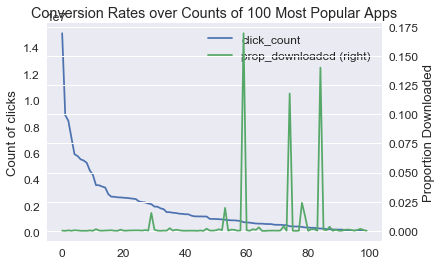

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      280     15065927         0.000270
1      245      8873025         0.000093
2      107      8457471         0.000504
3      477      7188340         0.000169
4      134      5924250         0.000595
5      259      5787004         0.000442
6      153      5537977         0.000138
7      265      5446388         0.000134
8      178      5271408         0.000119
9      121      4692438         0.000438
10     205      4359180         0.000120
11     145      3583945         0.001533
12     442      3574611         0.000358
13     459      3477150         0.000197
14     379      3402636         0.000335
15     439      2901762         0.000457
16     489      2711240         0.000569
17     128      2703163         0.000204
18     135      2663913         0.000125
19     466      2655396         0.001111


In [23]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

In [24]:
#convert click_time and attributed_time to time series
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

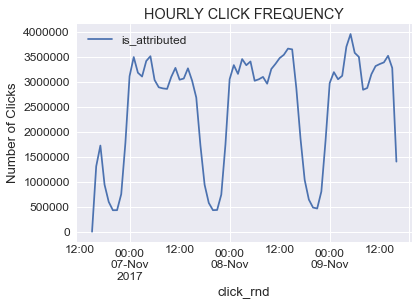

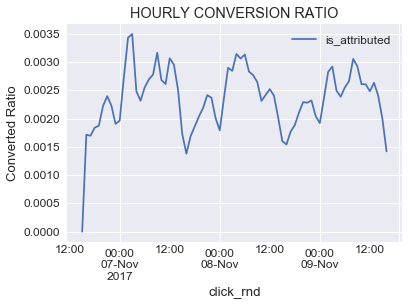

In [25]:
#round the time to nearest hour
train['click_rnd']=train['click_time'].dt.round('H')  

#check for hourly patterns
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [26]:
#extract hour as a feature
train['click_hour']=train['click_time'].dt.hour

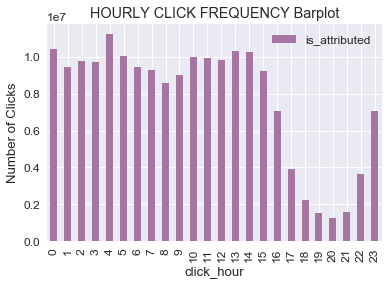

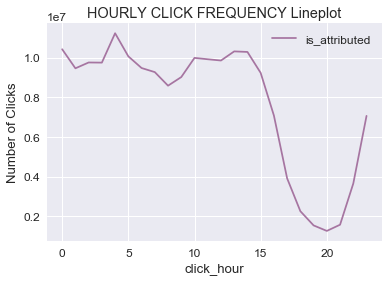

In [27]:
train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

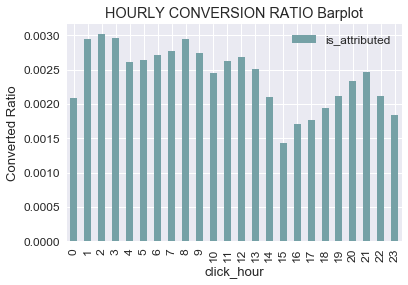

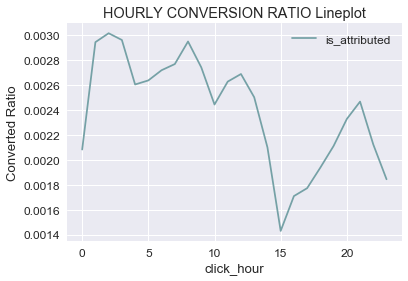

In [28]:
train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

In [29]:
### ML try1 ###

In [30]:
train.head(10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts,click_rnd,click_hour
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,25719,2017-11-06 15:00:00,14
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0,24133,2017-11-06 15:00:00,14
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0,9791,2017-11-06 15:00:00,14
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0,169149,2017-11-06 15:00:00,14
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0,1171,2017-11-06 15:00:00,14
5,18787,3,1,16,379,2017-11-06 14:36:26,NaT,0,3702,2017-11-06 15:00:00,14
6,103022,3,1,23,379,2017-11-06 14:37:44,NaT,0,5628,2017-11-06 15:00:00,14
7,114221,3,1,19,379,2017-11-06 14:37:59,NaT,0,1906,2017-11-06 15:00:00,14
8,165970,3,1,13,379,2017-11-06 14:38:10,NaT,0,2014,2017-11-06 15:00:00,14
9,74544,64,1,22,459,2017-11-06 14:38:23,NaT,0,3645,2017-11-06 15:00:00,14


In [31]:
x = train.iloc[:,1:5]

In [32]:
y = train.iloc[:,7]

In [33]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn import metrics

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
# 切分訓練與測試資料
train_X, test_X, train_y, test_y = train_test_split(x, y, test_size = 0.3)

In [35]:
# 建立分類器
clf = tree.DecisionTreeClassifier()
iris_clf = clf.fit(train_X, train_y)

In [36]:
# 預測
test_y_predicted = iris_clf.predict(test_X)

In [37]:
# 績效
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)

0.9980491306411491


In [38]:
### ML try1 ###